In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [0]:
dir_path = '/content/drive/My Drive/CS 280/dataset-resized'

classes = ('cardboard','glass', 'metal', 'paper', 'plastic', 'trash')
num_classes = 6

In [0]:
train_datagen=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1)
val_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator=train_datagen.flow_from_directory(dir_path,
                                                  target_size=(224,224),
                                                  batch_size=128,
                                                  class_mode='categorical',
                                                  subset='training',
                                                  seed = 30)

val_generator=val_datagen.flow_from_directory(dir_path,
                                              target_size=(224,224),
                                              batch_size=128,
                                              class_mode='categorical',
                                              subset='validation',
                                              seed = 30)

Found 2293 images belonging to 6 classes.
Found 252 images belonging to 6 classes.


In [0]:
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2
import itertools
%matplotlib inline

vgg16_model = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
for layer in vgg16_model.layers[:-1]:
    layer.trainable = False


vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg16_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(6, activation='softmax'))
model.add(Dense(6, activation='softmax', kernel_regularizer=l2(0.01)))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()
  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 25,697,286
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath='/content/drive/My Drive/CS 280/vgg+SVM final.h5'
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max', save_best_only=True)
callbacks_list = [checkpoint1]

model.compile(loss='categorical_hinge',
              optimizer= tensorflow.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False), 
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=val_generator,
      validation_steps=val_generator.samples/val_generator.batch_size,
      verbose=1,
      callbacks=callbacks_list)

Epoch 1/100
18/17 [==============================] - ETA: 0s - loss: 1.4369 - acc: 0.2499
Epoch 00001: val_acc improved from -inf to 0.17857, saving model to /content/drive/My Drive/CS 280/vgg+SVM final.h5
18/17 [==============================] - 39s 2s/step - loss: 1.4369 - acc: 0.2499 - val_loss: 1.2382 - val_acc: 0.1786
Epoch 2/100
18/17 [==============================] - ETA: 0s - loss: 1.2273 - acc: 0.3467
Epoch 00002: val_acc improved from 0.17857 to 0.38095, saving model to /content/drive/My Drive/CS 280/vgg+SVM final.h5
18/17 [==============================] - 39s 2s/step - loss: 1.2273 - acc: 0.3467 - val_loss: 1.2000 - val_acc: 0.3810
Epoch 3/100
18/17 [==============================] - ETA: 0s - loss: 1.1632 - acc: 0.3916
Epoch 00003: val_acc improved from 0.38095 to 0.42063, saving model to /content/drive/My Drive/CS 280/vgg+SVM final.h5
18/17 [==============================] - 39s 2s/step - loss: 1.1632 - acc: 0.3916 - val_loss: 1.1215 - val_acc: 0.4206
Epoch 4/100
18/17 [

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/CS 280/vgg+SVM last.h5')
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=val_generator,
      validation_steps=val_generator.samples/val_generator.batch_size,
      verbose=1,
      callbacks=callbacks_list)

Epoch 1/100
18/17 [==============================] - ETA: 0s - loss: 0.2649 - acc: 0.8836
Epoch 00001: val_acc improved from 0.16270 to 0.83730, saving model to /content/drive/My Drive/CS 280/vgg+SVM final.h5
18/17 [==============================] - 39s 2s/step - loss: 0.2649 - acc: 0.8836 - val_loss: 0.3325 - val_acc: 0.8373
Epoch 2/100
18/17 [==============================] - ETA: 0s - loss: 0.2776 - acc: 0.8700
Epoch 00002: val_acc improved from 0.83730 to 0.84524, saving model to /content/drive/My Drive/CS 280/vgg+SVM final.h5
18/17 [==============================] - 40s 2s/step - loss: 0.2776 - acc: 0.8700 - val_loss: 0.3448 - val_acc: 0.8452
Epoch 3/100
18/17 [==============================] - ETA: 0s - loss: 0.2817 - acc: 0.8731
Epoch 00003: val_acc did not improve from 0.84524
18/17 [==============================] - 37s 2s/step - loss: 0.2817 - acc: 0.8731 - val_loss: 0.3514 - val_acc: 0.8333
Epoch 4/100
18/17 [==============================] - ETA: 0s - loss: 0.2610 - acc: 0.

In [0]:
model.save('/content/drive/My Drive/CS 280/vgg+SVM last.h5')

In [0]:
np.save('/content/drive/My Drive/CS 280/VGG+SVM history2.npy', history.history) 

In [0]:
d1 = np.load('/content/drive/My Drive/CS 280/VGG+SVM history.npy',allow_pickle='TRUE').item()
d2 = np.load('/content/drive/My Drive/CS 280/VGG+SVM history2.npy',allow_pickle='TRUE').item()

In [0]:
model.evaluate_generator(generator=val_generator,steps=val_generator.samples/val_generator.batch_size)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.4147832691669464, 0.7976190447807312]

dict_keys(['acc', 'val_acc', 'loss', 'val_loss'])


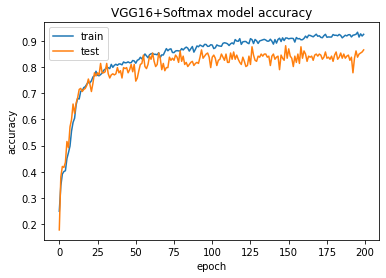

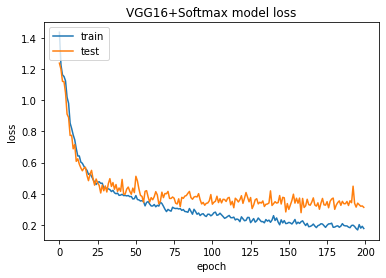

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(d1['acc']+d2['acc'])
plt.plot(d1['val_acc']+d2['val_acc'])
plt.title('VGG16+Softmax model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(d1['loss']+d2['loss'])
plt.plot(d1['val_loss']+d2['val_loss'])
plt.title('VGG16+Softmax model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()